In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/home/nvrancovich/.local/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [21]:
segments = gpd.read_file('segmentacion_general_san_martin.geojson')
segments.rename(columns={'Name':'area', 'description':'region'},inplace=True)

props = pd.read_csv('propiedades.csv', index_col=0)
props = gpd.GeoDataFrame(props, geometry=gpd.points_from_xy(props.longitude, props.latitude))
props = props.set_crs('EPSG:4326')


df = props.sjoin(segments, how='inner')
df.drop(columns = ['index_right','region','geometry'], inplace=True)
df['price/m2'] = df.price_USD / df.covered_surface_m2

segments_avg = df.groupby('area').mean()[['covered_surface_m2', 'antiquity', 'price_USD', 'price/m2']].reset_index(level=0)
df.drop(labels='price/m2', axis=1, inplace=True)
segments_avg = segments_avg[['area','price/m2']]
segments_avg = segments_avg.set_index('area')

df = df.join(segments_avg, how='inner',on='area')


df['bathrooms'] = df['bathrooms'].fillna(1)
df.dropna(subset=['bedrooms'], axis=0, inplace=True)
df.dropna(subset=['latitude'], axis=0, inplace=True)
df.dropna(subset=['covered_surface_m2'], axis=0, inplace=True)
df.dropna(subset=['price_USD'], axis=0, inplace=True)
df = df[df.bedrooms < 10]
df = df[['price_USD','type','covered_surface_m2','bedrooms','price/m2','bathrooms','latitude','longitude']]
df.reset_index(drop=True, inplace=True)

In [25]:
segments['latitude'] = segments.centroid.y
segments['longitude'] = segments.centroid.x

/tmp/ipykernel_23998/3297187047.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  segments['latitude'] = segments.centroid.y
/tmp/ipykernel_23998/3297187047.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  segments['longitude'] = segments.centroid.x


In [29]:
segments[['area','latitude', 'longitude']].to_csv('segmentos_centroides', index=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_USD           6408 non-null   float64
 1   type                6408 non-null   object 
 2   covered_surface_m2  6408 non-null   float64
 3   bedrooms            6408 non-null   float64
 4   price/m2            6408 non-null   float64
 5   bathrooms           6408 non-null   float64
 6   latitude            6408 non-null   float64
 7   longitude           6408 non-null   float64
dtypes: float64(7), object(1)
memory usage: 400.6+ KB


In [33]:
df = pd.get_dummies(df, columns=['type'])

In [34]:
df.corr().price_USD

price_USD             1.000000
covered_surface_m2    0.752415
bedrooms              0.569220
price/m2              0.100294
bathrooms             0.635766
latitude              0.015084
longitude             0.032035
type_casa             0.447782
type_departamento    -0.283204
type_ph              -0.178772
Name: price_USD, dtype: float64

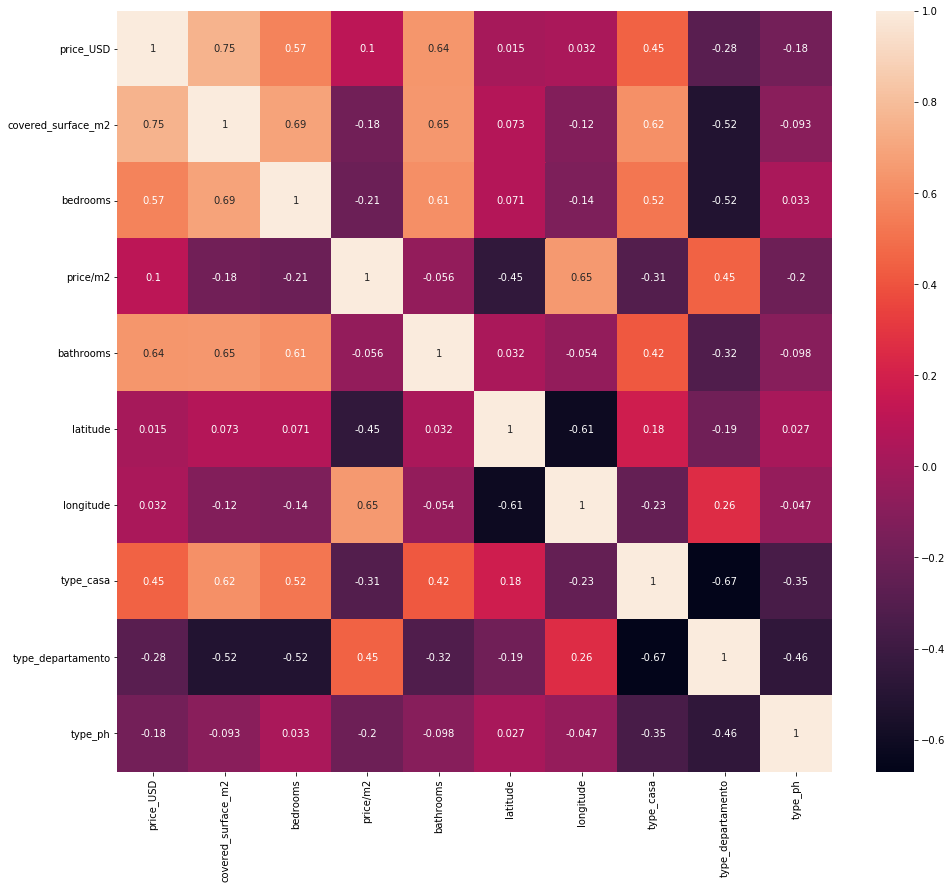

In [35]:
plt.figure(figsize=(16,14))
sns.heatmap(df.corr(), annot=True)

In [36]:
df = df[df.corr().columns]
df.info()
df.to_csv('propiedades_limpio.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6408 entries, 0 to 6407
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_USD           6408 non-null   float64
 1   covered_surface_m2  6408 non-null   float64
 2   bedrooms            6408 non-null   float64
 3   price/m2            6408 non-null   float64
 4   bathrooms           6408 non-null   float64
 5   latitude            6408 non-null   float64
 6   longitude           6408 non-null   float64
 7   type_casa           6408 non-null   uint8  
 8   type_departamento   6408 non-null   uint8  
 9   type_ph             6408 non-null   uint8  
dtypes: float64(7), uint8(3)
memory usage: 369.3 KB


In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X = df.loc[:,df.columns!='price_USD']
y = df.loc[:,'price_USD']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [17]:
from xgboost import XGBRegressor

In [18]:
xgboost_regressor = XGBRegressor()

In [19]:
parameters = {'random_state':[10,5],
              'gamma': [24.2,24.4,24.6] ,
              'learning_rate':[0.05],
              'max_depth':[6],
              'n_estimators':[500],
              'subsample':[0.8],
              'reg_lambda':[0.8]}

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
clf = GridSearchCV(xgboost_regressor, 
                   param_grid=parameters,
                   scoring='r2',
                   cv=5)

In [22]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             param_grid={'gamma': [24.2, 24.4, 24.6], 'learning_rate': [0.05],
                         'max_depth': [6], 'n_estimators': [500],
                         'random_state': [10, 5], 'reg_lambda': [0.8],
                         'subsample': [0.8]},
             scoring='r2')

In [24]:
clf.best_params_

{'gamma': 24.2,
 'learning_rate': 0.05,
 'max_depth': 6,
 'n_estimators': 500,
 'random_state': 10,
 'reg_lambda': 0.8,
 'subsample': 0.8}

In [23]:
clf.best_score_

0.7612146494266651

In [96]:
clf.best_score_

0.7338989626128987

In [25]:
xgboost_regressor = clf.best_estimator_

In [26]:
xgboost_regressor.fit(X, y.ravel())

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=24.2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=10,
             reg_alpha=0, reg_lambda=0.8, ...)

In [27]:
xgboost_regressor.save_model("xgboost_regressor.json")

In [6]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

xgboost_regressor = xgb.XGBRegressor()
xgboost_regressor.load_model("xgboost_regressor.json")

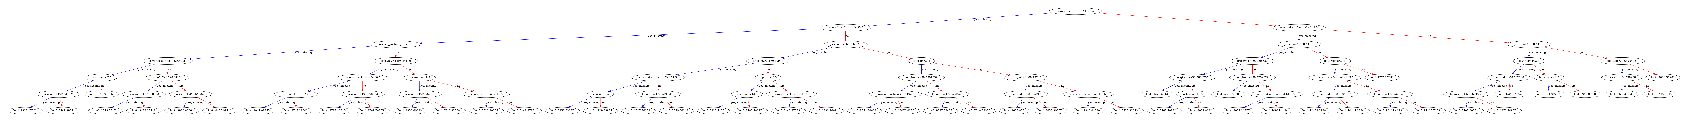

In [9]:
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(xgboost_regressor, num_trees=0, ax=ax)
plt.show()